# **Análisis de Características - 04_analisis_caracteristicas.ipynb**  

## **🎯 Objetivo del Notebook**  
Este notebook tiene como objetivo analizar la relevancia de las características en los datos EEG y aplicar técnicas de reducción de dimensionalidad para mejorar el rendimiento del modelo.  

## **📌 Contexto**  
En notebooks anteriores, entrenamos un modelo de Regresión Logística para la clasificación de eventos EEG. Sin embargo, la optimización del hiperparámetro C no resultó en mejoras significativas. Esto sugiere que la calidad de los datos podría estar limitando el rendimiento del modelo.  

Para abordar esto, en este análisis exploraremos estrategias de selección de características y reducción de dimensionalidad antes de probar modelos más complejos (XGBoost, LightGBM).  

---
## **📌 Estrategia**  
Transformaciones a realizar y consideraciones:

- **Eliminamos outliers antes de normalizar** ya que la normalización podría ocultar o reducir la diferencia entre outliers y valores normales.
- **Eliminamos características con baja varianza antes de normalizar**, evitando que la normalización enmascare su baja importancia.  
- **Analizamos correlaciones antes de normalizar**, ya que los cambios de escala pueden afectar las correlaciones, y sopesamos si utilizar PCA en función de los resultados.    
- **Usamos SelectKBest sobre los datos normalizados**, seleccionando las características con mayor impacto en la clasificación.  
- **Evaluamos el impacto de estos cambios comparando el rendimiento del modelo antes y después del preprocesamiento después de cada tranformación.**  

---

## **🚀 Flujo de Trabajo en este Notebook**  

En lugar de aplicar todo el preprocesamiento de una vez, **evaluaremos el impacto de cada transformación de manera individual**. Esto nos permitirá comprobar si cada técnica realmente mejora el rendimiento antes de aplicarla de forma definitiva.  

Por lo tanto, **tras cada filtro aplicado, , normalizaremos los datos y compararemos el rendimiento del modelo Regresión Logística** para decidir si continuamos con la transformación o revertimos los cambios.  

1️⃣ **Cargar los datos sin preprocesar**  
2️⃣ **Aplicar cada técnica de preprocesamiento de forma independiente**  
3️⃣ **Normalizar los datos antes de cada evaluación**  
4️⃣ **Comparar el rendimiento del modelo tras cada preprocesamiento**  
5️⃣ **Decidir si mantener o descartar cada transformación**   
6️⃣ **Conclusiones y próximos pasos.**    

## **1. Carga de Datos**

In [33]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from collections import Counter

DATA_PATH = r"C:\Users\luciaft\Documents\TFG\TFG\graspAndLiftDetectionTFGProyect\data\raw_data\train\train"
SUBJECT = "subj1"
SERIES_TRAIN = [f"{SUBJECT}_series{i}_data.csv" for i in range(1, 9)]
SERIES_EVENTS = [f"{SUBJECT}_series{i}_events.csv" for i in range(1, 9)]

def load_data(series, path=DATA_PATH):
    dfs = [pd.read_csv(os.path.join(path, file)) for file in series]
    return pd.concat(dfs, ignore_index=True)

df_train = load_data(SERIES_TRAIN)
df_events = load_data(SERIES_EVENTS)
df = df_train.merge(df_events, on="id")

eeg_columns = df.columns[1:33]  # Columnas de señales EEG
event_columns = ["HandStart", "FirstDigitTouch", "BothStartLoadPhase", "LiftOff", "Replace", "BothReleased"]

df_sujeto1 = df[df["id"].str.startswith("subj1_series")]
df_train = df_sujeto1[df_sujeto1["id"].str.contains("series[1-6]_")]
df_valid = df_sujeto1[df_sujeto1["id"].str.contains(r"series[7-8]_", regex=True)]

X_train, y_train = df_train[eeg_columns], df_train[event_columns]
X_valid, y_valid = df_valid[eeg_columns], df_valid[event_columns]

## **2. Función de Evaluación**

A pesar de que decidimos dividir los datos en entrenamiento y validación, para el preprocesamiento utilizaremos validación cruzada sobre el subconjunto de entrenamiento, ya que nos permite evaluar el impacto de cada transformación de forma más robusta, al promediar el rendimiento sobre múltiples particiones del entrenamiento. Así evitamos depender del azar de un único subconjunto (`X_valid`) y tomamos decisiones más fiables antes de hacer una evaluación final con el conjunto de validación reservado.

In [34]:
def evaluate_model(X_train, y_train, event_name):
    model = LogisticRegression()
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"{event_name}: ROC AUC Score: {np.mean(scores):.4f} \u00b1 {np.std(scores):.4f}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

print("Evaluación con solo normalización:")
for event in event_columns:
    evaluate_model(X_train_scaled, y_train[event], event)

Evaluación con solo normalización:
HandStart: ROC AUC Score: 0.7605 ± 0.0495
FirstDigitTouch: ROC AUC Score: 0.7809 ± 0.0983
BothStartLoadPhase: ROC AUC Score: 0.7439 ± 0.0979
LiftOff: ROC AUC Score: 0.7528 ± 0.0782
Replace: ROC AUC Score: 0.8609 ± 0.0451
BothReleased: ROC AUC Score: 0.7902 ± 0.0402


## **2. Eliminación de Outliers y Evaluación del Impacto en el Modelo**

Ya detectamos **valores extremos** en `01_preprocesamiento.ipynb`, por lo que aquí aplicamos un filtro basado en Z-score y según los resultados decidiremos si continuar con los datos filtrados o no.

In [43]:
z_scores = np.abs(zscore(X_train))
outlier_threshold = 3
mask = (z_scores < outlier_threshold).all(axis=1)
X_train_filtered = X_train[mask]
y_train_filtered = y_train[mask]
X_valid_filtered = X_valid[X_train_filtered.columns]  # Igualar columnas para cuando utilicemos subconjunto validación


X_train_filtered_scaled = scaler.fit_transform(X_train_filtered)

print("Evaluación tras eliminación de outliers:")
for event in event_columns:
    evaluate_model(X_train_filtered_scaled, y_train_filtered[event], event)

Evaluación tras eliminación de outliers:
HandStart: ROC AUC Score: 0.7790 ± 0.0283
FirstDigitTouch: ROC AUC Score: 0.8105 ± 0.0692
BothStartLoadPhase: ROC AUC Score: 0.7709 ± 0.0766
LiftOff: ROC AUC Score: 0.7716 ± 0.0730
Replace: ROC AUC Score: 0.8751 ± 0.0371
BothReleased: ROC AUC Score: 0.8042 ± 0.0393


🟢 **La eliminación de Outliers mejoró los resultados de Regresión Logistica**, por tanto, **utilizaremos los datos filtrados para el análisis de la varianza**. Esto se debe a que los outliers pueden influir en la varianza de las características, lo que podría llevar a la eliminación de características que en realidad son relevantes solo porque tienen valores extremos. Así, tomamos decisiones basadas en datos más representativos y sin sesgos provocados por valores extremos.

## **3. Análisis de la Varianza de las Características EEG**

Como el `StandardScaler` ya ha normalizado los datos, usamos `VarianceThreshold` **para eliminar características con baja variabilidad.**

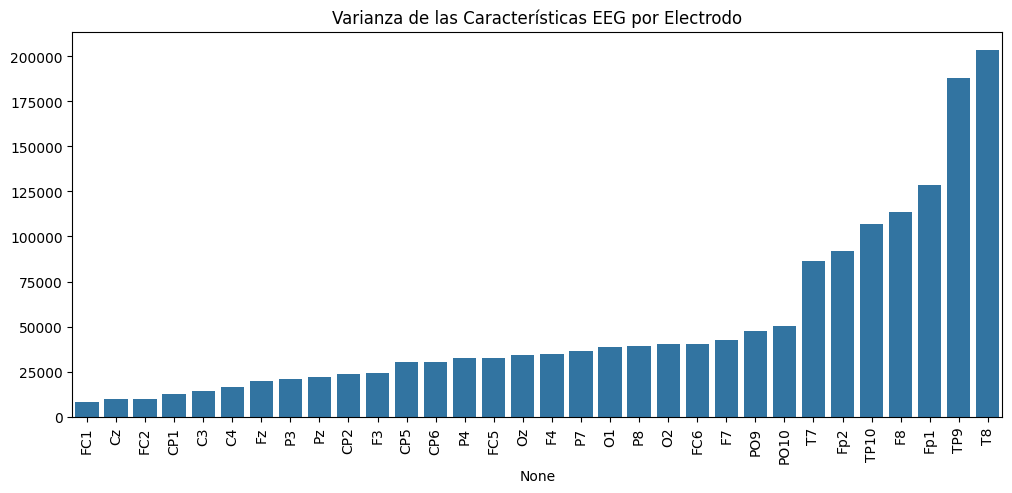

FC1       8371.990834
Cz        9798.043374
FC2       9944.200949
CP1      12886.182303
C3       14204.412593
C4       16312.172712
Fz       19678.626757
P3       20951.338248
Pz       21881.438018
CP2      23547.823300
F3       24313.481271
CP5      30142.912763
CP6      30683.853786
P4       32522.975885
FC5      32812.760200
Oz       34250.561453
F4       34864.678530
P7       36310.016939
O1       38980.823003
P8       39515.732662
O2       40236.691693
FC6      40290.867729
F7       42567.085736
PO9      47430.339816
PO10     50365.931383
T7       86561.397048
Fp2      92046.248271
TP10    106995.912601
F8      113470.312078
Fp1     128434.153760
TP9     187763.374768
T8      203286.798899
dtype: float64


In [36]:

# Calcular varianza de cada electrodo
feature_variances = X_train.var().sort_values(ascending=True)

# Visualizar la varianza de las características
plt.figure(figsize=(12, 5))
sns.barplot(x=feature_variances.index, y=feature_variances.values)
plt.xticks(rotation=90)
plt.title("Varianza de las Características EEG por Electrodo")
plt.show()

print(feature_variances)

### **Análisis de la distribución de las varianzas**

- **Varianza más baja**: `FC1 = 8,371`
- **Varianza más alta**: `T8 = 203,286`
- **Mediana aproximada**: Al estar los valores distribuidos de manera creciente, la mediana parece estar en el rango de `30,000 - 40,000`.
- **Valores más bajos**: Los electrodos `FC1`, `Cz`, `FC2`, `CP1`, `C3` tienen varianzas menores a `15,000`.

#### **¿Qué umbral usar en `VarianceThreshold`?**
🟢 No hay valores de varianza extremadamente baja en ninguno de los electrodos, probaremos a eliminar solo un electrodo fijando el umbral en **9,000** por mostrar los cambios en los resultados, pero es probable casi no varien o que empeoren levemente porque **no es necesario eliminar ningún electrodo basado en varianza baja, ya que ninguna de las varianzas es lo suficientemente pequeña como para indicar una falta de variabilidad significativa en la señal del electrodo.**

In [37]:
# Aplicar filtro de varianza sobre los datos ya sin outliers
selector_var = VarianceThreshold(threshold=9000)
X_train_var = selector_var.fit_transform(X_train_filtered)

# Normalizar después del filtrado
X_train_var_scaled = scaler.fit_transform(X_train_var)

print("Evaluación tras eliminación de baja varianza:")
for event in event_columns:
    evaluate_model(X_train_var_scaled, y_train_filtered[event], event)

Evaluación tras eliminación de baja varianza:
HandStart: ROC AUC Score: 0.7792 ± 0.0229
FirstDigitTouch: ROC AUC Score: 0.8096 ± 0.0660
BothStartLoadPhase: ROC AUC Score: 0.7677 ± 0.0728
LiftOff: ROC AUC Score: 0.7662 ± 0.0696
Replace: ROC AUC Score: 0.8775 ± 0.0354
BothReleased: ROC AUC Score: 0.8040 ± 0.0366


🟢 **Efectivamente, los resultados casi no varían y empeoran ligeramente en la mayoría de los casos, por lo que continuamos con los datos simplemente sin outliers**

## **4. Análisis de Correlaciones**

Si algunas señales EEG están altamente correlacionadas, es posible que sean redundantes. Si hubiera muchas correlaciones superiores a 0.9, aplicaríamos `PCA` para reducir dimensionalidad.

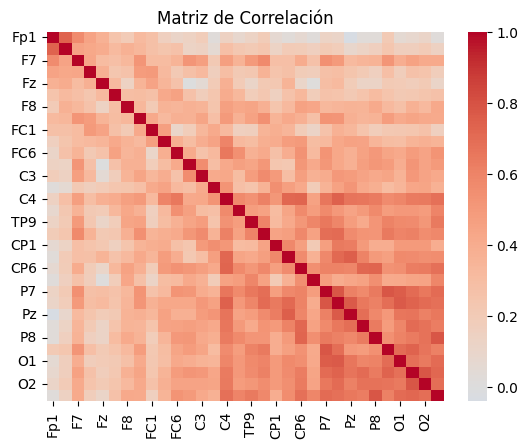

     Electrodo 1 Electrodo 2  Correlación
863           P8        PO10     0.786129
1018        PO10          P8     0.786129
731           P7         PO9     0.785078
886          PO9          P7     0.785078
989           O2          Oz     0.781884
958           Oz          O2     0.781884
727           P7          P3     0.781133
758           P3          P7     0.781133
764           P3          O1     0.771908
919           O1          P3     0.771908


In [38]:
# Calcular la matriz de correlación
correlation_matrix = pd.DataFrame(X_train_filtered).corr()

# Mapa de calor de correlación entre electrodos
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title("Matriz de Correlación")
plt.show()

# Desenrollar la matriz de correlación en formato de lista ordenada
correlation_unrolled = correlation_matrix.unstack().reset_index()
correlation_unrolled.columns = ["Electrodo 1", "Electrodo 2", "Correlación"]

# Filtrar para quitar la diagonal (correlación de un electrodo consigo mismo siempre es 1)
correlation_unrolled = correlation_unrolled[correlation_unrolled["Electrodo 1"] != correlation_unrolled["Electrodo 2"]]

# Ordenar de mayor a menor
correlation_unrolled = correlation_unrolled.sort_values(by="Correlación", ascending=False)

# Mostrar las 10 correlaciones más altas
print(correlation_unrolled.head(10))

#### **Resultados**
- **No hay señales EEG con correlación > 0.9**, por lo que **NO es necesario aplicar `PCA` por redundancia.**  
- **Todas las señales tienen correlaciones similares, moderadamente altas (~0.8), pero no lo suficientemente extremas para justificar una reducción automática.**  

#### **Conclusión**
🟢 **Mantenemos todas las señales EEG y pasamos a `SelectKBest` para seleccionar las más relevantes.**    

## **5. Selección de características con ANOVA (`SelectKBest`)**

**Seleccionamos las 20 características más relevantes** en cada evento EEG utilizando **`SelectKBest`** con la **métrica ANOVA F-value**. Esto permite reducir la cantidad de datos sin perder información clave.  

Para cada uno de los 6 eventos, **filtramos las características que mejor diferencian entre presencia y ausencia del evento** y guardamos el conjunto de características seleccionadas. 

Luego, analizamos **cuáles características fueron seleccionadas con más frecuencia en todos los eventos**. Si la mayoría son comunes, **usaremos un solo conjunto optimizado**; si hay mucha variabilidad, **mantendremos selecciones individuales por evento**

In [39]:
# Diccionario para almacenar las características seleccionadas por evento
selected_features = {}
feature_support_masks = {}
event_summary = []

# Convertir y_train_filtered a NumPy
y_train_array = y_train_filtered.to_numpy()

for event in range(y_train_filtered.shape[1]):  
    k_best = SelectKBest(score_func=f_classif, k=20)  
    X_train_best = k_best.fit_transform(X_train_filtered_scaled, y_train_array[:, event])  

    mask = k_best.get_support()
    selected_feature_names = np.array(eeg_columns)[mask]

    # Guardar las características seleccionadas para este evento
    selected_features[f"Evento_{event+1}"] = X_train_best
    feature_support_masks[f"Evento_{event+1}"] = selected_feature_names

    # Agregar al resumen
    event_summary.append(
        f"Evento {event+1}: {X_train_best.shape[1]} características seleccionadas\n"
        f"Características más relevantes: {', '.join(selected_feature_names)}"
    )

# Imprimir resumen final de los eventos
print("\n**Resumen de Selección de Características**")
for summary in event_summary:
    print(summary)

# Contar frecuencia de aparición de cada característica
feature_counter = Counter()

for selected_feature_names in feature_support_masks.values():
    feature_counter.update(selected_feature_names)

# Características seleccionadas en todos los eventos
common_features = [feat for feat, count in feature_counter.items() if count == len(selected_features)]

print("\n**Características Comunes en Todos los Eventos**")
print(", ".join(common_features))
print(f"\nTotal de características comunes: {len(common_features)} de 20 posibles.")
print(f"{len(feature_counter)} características fueron seleccionadas al menos en un evento.")


**Resumen de Selección de Características**
Evento 1: 20 características seleccionadas
Características más relevantes: F7, F3, Fz, FC5, T7, C4, T8, CP5, CP1, CP2, CP6, P7, P3, Pz, P4, P8, PO9, O1, Oz, O2
Evento 2: 20 características seleccionadas
Características más relevantes: Fp1, Fp2, FC6, T7, C4, T8, TP9, CP5, CP2, CP6, TP10, P7, P3, Pz, P4, P8, O1, Oz, O2, PO10
Evento 3: 20 características seleccionadas
Características más relevantes: Fp1, F8, FC6, T7, C4, T8, TP9, CP5, CP2, CP6, TP10, P7, P3, Pz, P4, P8, O1, Oz, O2, PO10
Evento 4: 20 características seleccionadas
Características más relevantes: Fp1, F7, F8, FC2, FC6, C4, T8, TP9, CP2, CP6, TP10, P7, P3, Pz, P4, P8, O1, Oz, O2, PO10
Evento 5: 20 características seleccionadas
Características más relevantes: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, C3, T8, CP2, P7, P3, Pz, P8, PO9, O1, Oz, PO10
Evento 6: 20 características seleccionadas
Características más relevantes: Fp1, Fp2, F7, F3, Fz, FC1, FC6, C3, C4, T8, CP1, CP2, CP6, P7, P3

#### Análisis de la Selección de Características

Tras aplicar `SelectKBest` de forma independiente a cada evento, observamos que **las características seleccionadas no son exactamente las mismas** para todos los eventos. De las 20 seleccionadas por evento, solo **7 características** son comunes en todos los casos.

### ¿Qué implica este resultado?

- Existe cierta **consistencia** en algunas características EEG que aparecen repetidamente, lo que sugiere que podrían ser especialmente informativas de manera general.
- Aun así, **no hemos evaluado todavía si usar solo esas características comunes permite mantener un buen rendimiento**.
- Este enfoque tiene el potencial de **reducir la dimensionalidad**, simplificar el modelo y disminuir el riesgo de sobreajuste, siempre que la pérdida de información no afecte al AUC.

---
Vamos a probar el rendimiento del modelo utilizando **las 20 características más frecuentes seleccionadas por `SelectKBest` en cada evento**, comparándolo con el modelo que utiliza **todas las características disponibles** tras la eliminación de outliers.

Esta estrategia busca conservar las variables que han demostrado ser informativas de forma consistente entre eventos, lo que permite **reducir la dimensionalidad** sin perder demasiada información relevante. Si el rendimiento se mantiene o mejora, podremos adoptar este subconjunto optimizado para futuras etapas del proyecto.

In [40]:
# ✅ Reemplaza las características comunes por las 20 más frecuentes

# Obtener las 20 características más frecuentes entre eventos (calculadas previamente)
top_25_features = [feat for feat, _ in feature_counter.most_common(25)]

print("Top 25 características más frecuentes entre eventos:")
print(top_25_features)

# Filtrar X_train y X_valid con las top 20
X_train_best = X_train_filtered[top_25_features].values
X_valid_best = X_valid[top_25_features].values

# Aplicar normalización sobre este subconjunto
scaler_best = StandardScaler()
X_train_best_scaled = scaler_best.fit_transform(X_train_best)
X_valid_best_scaled = scaler_best.transform(X_valid_best)

# Verificar dimensiones
print(f"Nuevo tamaño de X_train con top 20 features: {X_train_best_scaled.shape}")
print(f"Nuevo tamaño de X_valid con top 20 features: {X_valid_best_scaled.shape}")

Top 25 características más frecuentes entre eventos:
['T8', 'CP2', 'P7', 'P3', 'Pz', 'P8', 'O1', 'C4', 'CP6', 'P4', 'Oz', 'Fp1', 'PO10', 'F7', 'O2', 'FC6', 'F3', 'Fz', 'T7', 'CP5', 'Fp2', 'TP9', 'TP10', 'F8', 'FC5']
Nuevo tamaño de X_train con top 20 features: (1043205, 25)
Nuevo tamaño de X_valid con top 20 features: (236894, 25)


## **6. Comparación de Modelos**

 Evaluamos si el modelo mejora en comparación con usar todas las características originales.

In [41]:
print("\n**Comparación de Modelos por Evento**")

# Aplicar normalización a los datos con todas las características
scaler_all = StandardScaler()
X_train_filtered_scaled = scaler_all.fit_transform(X_train_filtered)

# Aplicar normalización a los datos con las 20 características seleccionadas
scaler_best = StandardScaler()
X_train_best_scaled = scaler_best.fit_transform(X_train_best)

# Iterar sobre cada evento
for event in event_columns:
    print(f"\nEvaluando Modelo para {event}...")

    # Etiqueta del evento actual
    y_train_event = y_train_filtered[event]

    # Evaluar modelo con todas las características (tras eliminar outliers)
    auc_score_original = evaluate_model(X_train_filtered_scaled, y_train_event, f"{event} (Outliers Removed)")

    # Evaluar modelo con las características seleccionadas (comunes)
    auc_score_best = evaluate_model(X_train_best_scaled, y_train_event, f"{event} (Outliers + SelectKBest)")


**Comparación de Modelos por Evento**

Evaluando Modelo para HandStart...
HandStart (Outliers Removed): ROC AUC Score: 0.7790 ± 0.0283
HandStart (Outliers + SelectKBest): ROC AUC Score: 0.7304 ± 0.0351

Evaluando Modelo para FirstDigitTouch...
FirstDigitTouch (Outliers Removed): ROC AUC Score: 0.8105 ± 0.0692
FirstDigitTouch (Outliers + SelectKBest): ROC AUC Score: 0.7582 ± 0.0674

Evaluando Modelo para BothStartLoadPhase...
BothStartLoadPhase (Outliers Removed): ROC AUC Score: 0.7709 ± 0.0766
BothStartLoadPhase (Outliers + SelectKBest): ROC AUC Score: 0.6906 ± 0.0757

Evaluando Modelo para LiftOff...
LiftOff (Outliers Removed): ROC AUC Score: 0.7716 ± 0.0730
LiftOff (Outliers + SelectKBest): ROC AUC Score: 0.6987 ± 0.0849

Evaluando Modelo para Replace...
Replace (Outliers Removed): ROC AUC Score: 0.8751 ± 0.0371
Replace (Outliers + SelectKBest): ROC AUC Score: 0.8735 ± 0.0349

Evaluando Modelo para BothReleased...
BothReleased (Outliers Removed): ROC AUC Score: 0.8042 ± 0.0393
BothR

#### **Resumen de Resultados**
- **El modelo con todas las características superó en todos los casos al modelo con SelectKBest.**   
- Esto indica que **eliminar características puede estar afectando negativamente la capacidad del modelo para capturar información relevante.**

#### **Decisión**
🟢 **No utilizaremos SelectKBest**, ya que la reducción de características no mejoró el rendimiento.  
🟢 **Seguiremos trabajando con todas las características originales**, ya que ofrecen mejor AUC en todos los eventos.  

## **7. Evaluar con Subconjunto de Validación y Guardar Datos**

In [44]:
print("\n📈 Evaluación final con subconjunto de validación (X_valid_filtered_scaled):")

# Diccionario para guardar resultados
auc_valid_results = {}

# Asegurar que X_valid tenga las mismas columnas que X_train_filtered
X_valid_filtered_scaled = scaler.transform(X_valid_filtered)

for event in event_columns:
    y_train_event = y_train_filtered[event]
    y_valid_event = y_valid[event]

    # Entrenar modelo con TODO el X_train filtrado y escalado
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_filtered_scaled, y_train_event)

    # Predecir probabilidades sobre X_valid
    y_pred_proba = model.predict_proba(X_valid_filtered_scaled)[:, 1]

    # Calcular AUC sobre y_valid
    auc = roc_auc_score(y_valid_event, y_pred_proba)
    auc_valid_results[event] = round(auc, 4)

    print(f"{event}: AUC-ROC (validación real) = {auc:.4f}")


📈 Evaluación final con subconjunto de validación (X_valid_filtered_scaled):
HandStart: AUC-ROC (validación real) = 0.7180
FirstDigitTouch: AUC-ROC (validación real) = 0.6940
BothStartLoadPhase: AUC-ROC (validación real) = 0.6922
LiftOff: AUC-ROC (validación real) = 0.7462
Replace: AUC-ROC (validación real) = 0.8501
BothReleased: AUC-ROC (validación real) = 0.8080


In [45]:
# Definir ruta de guardado
processed_path = r"C:\Users\luciaft\Documents\TFG\TFG\graspAndLiftDetectionTFGProyect\data\processed"
os.makedirs(processed_path, exist_ok=True)

# Guardar datos preprocesados (solo outliers eliminados + escalado)
with open(os.path.join(processed_path, "preprocessed_data_outliers_scaled.pkl"), "wb") as f:
    pickle.dump((X_train_filtered_scaled, y_train_filtered, X_valid_filtered_scaled, y_valid), f)

# Guardar en CSV
pd.DataFrame(X_train_filtered_scaled).to_csv(os.path.join(processed_path, "X_train_outliers.csv"), index=False)
pd.DataFrame(y_train_filtered).to_csv(os.path.join(processed_path, "y_train_outliers.csv"), index=False)
pd.DataFrame(X_valid_filtered_scaled).to_csv(os.path.join(processed_path, "X_valid_outliers.csv"), index=False)
pd.DataFrame(y_valid).to_csv(os.path.join(processed_path, "y_valid_outliers.csv"), index=False)

# Guardar resultados AUC 
auc_df = pd.DataFrame.from_dict(auc_valid_results, orient='index', columns=['AUC'])
auc_df.index.name = 'Evento'
auc_df.to_csv(os.path.join(processed_path, "auc_results_outliers.csv"))

## **📌 Conclusión y Próximos Pasos**

En este análisis, exploramos diferentes técnicas de preprocesamiento para mejorar la clasificación de eventos EEG. La eliminación de outliers fue la única técnica que mejoró el rendimiento del modelo, mientras que la selección de características y la reducción de dimensionalidad no generaron mejoras e incluso empeoraron los resultados.
 
Dado que los EEG son señales temporales, abordaremos la **ingeniería de características** en el siguiente notebook. Aplicaremos técnicas como:
- **Extracción de características temporales** (medias móviles, desviaciones estándar, gradientes).
- **Transformadas en el dominio de la frecuencia** (FFT, densidad espectral de potencia).
- **Derivadas y tasas de cambio** (diferencias entre muestras consecutivas).
 
Esto nos permitirá capturar mejor la información presente en la señal y mejorar la capacidad predictiva del modelo antes de considerar modelos más avanzados, asegurándonos de que estamos alimentando a los modelos con los mejores datos posibles, ya que si los datos no están bien preparados, incluso los modelos más sofisticados pueden dar malos resultados.
 
Si la ingeniería de características aporta mejoras significativas continuaremos con los datos preprocesados a través de estas técnicas, en caso contrario, sólo con la normalización y eliminación de outliers, para más adelante proceder a **probar modelos más avanzados** (XGBoost, Redes Neuronales, etc.).
 
 ---
**Continuamos pues en `05_ingenieria_caracteristicas.ipynb` para comenzar con la ingeniería de características.**